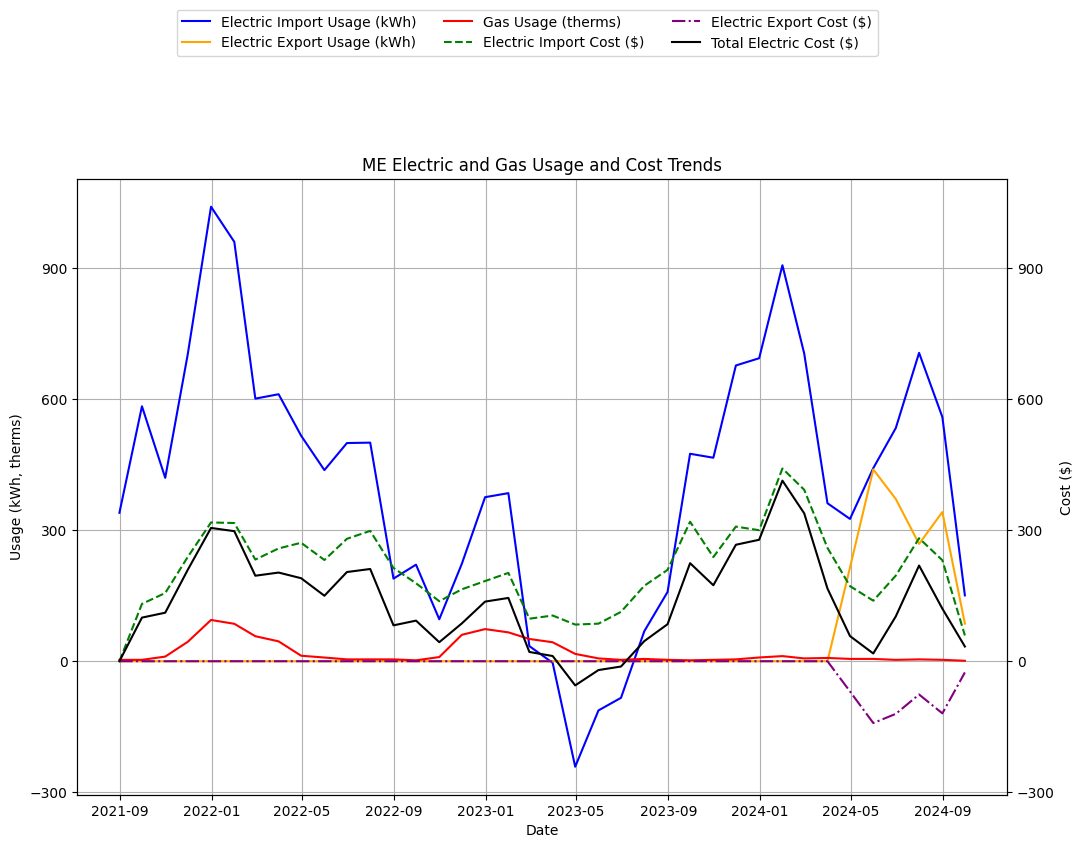

In [52]:
import warnings
warnings.simplefilter('default')  # Ensure all warnings are shown

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set aggregation period: 'D' for daily, 'W' for weekly, 'ME' for month-end
aggregation_period = 'ME'

# Load electric and gas data
electric_files = glob.glob('pge_electric_usage_interval_data_Service*.csv')
gas_files = glob.glob('pge_natural_gas_usage_interval_data_*.csv')

def load_and_process_files(files, columns_to_drop, usage_col=None):
    dataframes = []
    for file in files:
        try:
            with open(file, 'r') as f:
                header_index = next((i for i, line in enumerate(f) if "TYPE" in line and "DATE" in line), None)
                if header_index is not None:
                    df = pd.read_csv(file, skiprows=header_index)
                    if columns_to_drop in df.columns:
                        df.drop(columns=[columns_to_drop], inplace=True)
                    if usage_col and usage_col in df.columns:
                        df.rename(columns={usage_col: "IMPORT (kWh)"}, inplace=True)
                        df["EXPORT (kWh)"] = 0
                    dataframes.append(df)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    return pd.concat(dataframes, ignore_index=True) if dataframes else None

electric_data = load_and_process_files(electric_files, 'NOTES', 'USAGE (kWh)')
gas_data = load_and_process_files(gas_files, 'NOTES')

# Process electric data
if electric_data is not None:
    electric_data['DATE'] = pd.to_datetime(electric_data['DATE'], errors='coerce')
    electric_data['COST'] = pd.to_numeric(electric_data['COST'].replace({r'\$': ''}, regex=True), errors='coerce').ffill().fillna(0)
    electric_data['Import Cost'] = electric_data['COST'].where(electric_data['IMPORT (kWh)'] > 0, 0)
    electric_data['Export Cost'] = electric_data['COST'].where(electric_data['EXPORT (kWh)'] > 0, 0)
    electric_data.set_index('DATE', inplace=True)

# Process gas data
if gas_data is not None:
    gas_data['DATE'] = pd.to_datetime(gas_data['DATE'], errors='coerce')
    gas_data['COST'] = pd.to_numeric(gas_data['COST'].replace({r'\$': ''}, regex=True), errors='coerce').ffill().fillna(0)
    gas_data.set_index('DATE', inplace=True)

# Aggregate data for plotting
if electric_data is not None and gas_data is not None:
    electric_agg = electric_data.resample(aggregation_period).agg({'IMPORT (kWh)': 'sum', 'EXPORT (kWh)': 'sum', 'COST': 'sum', 'Import Cost': 'sum', 'Export Cost': 'sum'}).reset_index()
    gas_agg = gas_data.resample(aggregation_period).agg({'USAGE (therms)': 'sum', 'COST': 'sum'}).reset_index()

    # Filter out rows with all zero values for plotting
    electric_agg = electric_agg[(electric_agg[['IMPORT (kWh)', 'EXPORT (kWh)', 'COST', 'Import Cost', 'Export Cost']] != 0).any(axis=1)]
    gas_agg = gas_agg[(gas_agg[['USAGE (therms)', 'COST']] != 0).any(axis=1)]

    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(electric_agg['DATE'], electric_agg['IMPORT (kWh)'], label='Electric Import Usage (kWh)', color='blue')
    ax1.plot(electric_agg['DATE'], electric_agg['EXPORT (kWh)'], label='Electric Export Usage (kWh)', color='orange')
    ax1.plot(gas_agg['DATE'], gas_agg['USAGE (therms)'], label='Gas Usage (therms)', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Usage (kWh, therms)')
    ax1.grid(True)
    ax1.yaxis.set_major_locator(MaxNLocator(5))

    ax2 = ax1.twinx()
    ax2.plot(electric_agg['DATE'], electric_agg['Import Cost'], label='Electric Import Cost ($)', color='green', linestyle='--')
    ax2.plot(electric_agg['DATE'], electric_agg['Export Cost'], label='Electric Export Cost ($)', color='purple', linestyle='-.')
    ax2.plot(electric_agg['DATE'], electric_agg['COST'], label='Total Electric Cost ($)', color='black')
    ax2.set_ylabel('Cost ($)')
    ax2.yaxis.set_major_locator(MaxNLocator(5))

    # Calculate common min/max for both Y-axes
    min_y = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
    max_y = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

    # Set both axes to the same limits
    ax1.set_ylim(min_y, max_y)
    ax2.set_ylim(min_y, max_y)

    # Combine legends at the top
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.title(f'{aggregation_period} Electric and Gas Usage and Cost Trends')
    plt.show()
else:
    print("No data could be normalized from the files.")
